In [1]:
from autoencoder.unet import UNet
from clickref.model import Clickref
import torch
from autoencoder.dataloader import * 
import matplotlib.pyplot as plt
from tqdm import tqdm
from create_gt_grids import Gtgrid
from sklearn.metrics import pairwise_distances
from utils import *
from find_same_nucleis import FindSame2
from grids_to_clicks import Grid_to_click
from clickref.metrics import model_predict_with_click
from clickref.metrics import n_channel_to_rgb
from matching import matching
from clickref.dataloader import CustomImageDataset
from skimage.measure import label
from skimage.morphology import binary_dilation, disk
from scipy.special import softmax
from beautifultable import BeautifulTable
from sklearn.manifold import TSNE
from PIL import Image
from glob import glob
from autoencoder.unet import UNet
from scipy.special import softmax
from time import time


### Load the 2 models

In [2]:
autoencoder = UNet(3, 3)
device = torch.device('cpu')
autoencoder.to('cpu')
autoencoder.load_state_dict(
    torch.load(path_weights_autoencoder, map_location=device))
clickref = Clickref(3, 3)
clickref.load_state_dict(
    torch.load(path_weights_clickref, map_location=device)
)

<All keys matched successfully>

## 1. Autoencoder visualisation of the embedding space

In [3]:
features = np.load(os.path.join(path_encodings,'encodings128_0.0001.npy'))

In [4]:
features_one_rot = np.mean(features,axis = -1)

tsne = TSNE(n_components=2).fit_transform(features_one_rot[:3000])
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

KeyboardInterrupt: 

In [5]:
width = 4000
height = 3000
max_dim = 100
images = glob(path_twins+'/*.tif')[:3000]
full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = tifffile.imread(img).astype(np.uint8)
    tile =Image.fromarray(tile)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.LANCZOS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (20,20))
plt.imshow(full_image)
plt.axis('off')

KeyboardInterrupt: 

In [4]:
def display_side_by_side(image_array1, image_array2):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(1, 5))

    # Display the first image on the left subplot
    axs[0].imshow(image_array1)
    axs[0].axis('off')

    # Display the second image on the right subplot
    axs[1].imshow(image_array2)
    axs[1].axis('off')
    # Show the plots
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


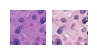

In [5]:
index = 50
filename = os.listdir(path_images)[index]
image_input = tifffile.imread(os.path.join(path_images,filename))/255
image = torch.tensor(np.transpose(image_input,(-1,0,1))[None]).float()
img = np.transpose(autoencoder(image)[0].detach().numpy()[0],(1,2,0))
display_side_by_side(image_input, img)

## 2. Click ref get results

In [5]:
dataset_test = CustomImageDataset(
    path_baseline=path_stardist,
    path_images=path_images,
    path_gt=path_gt,
    dataframe=df_test,
    augmenter_bool=False,
)

loader_test = DataLoader(
    batch_size=parameters["batch_size"],
    dataset=dataset_test,
    shuffle=False,
)

In [8]:
arr_baselines, arr_gts, arr_preds, arr_clicks = test_clickref(clickref, loader_test)

  0%|                                                    | 0/38 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
disk_size = 2
size_erase = 15
get_results(disk_size, size_erase, arr_baselines, arr_gts, arr_preds, arr_clicks)

## 3. Evaluate click-ref and CAE

In [9]:
pairwise_distances = np.load('autoencoder/pairwise_distances.npy')

In [10]:
f = FindSame2(df_test,
              autoencoder,
              threshold_images=1e-4,
              threshold_nucleis=1e-2,
              baseline = path_stardist,
              pairwise_similarities=pairwise_distances
              )

100%|███████████████████████████████████████████| 38/38 [00:37<00:00,  1.02it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


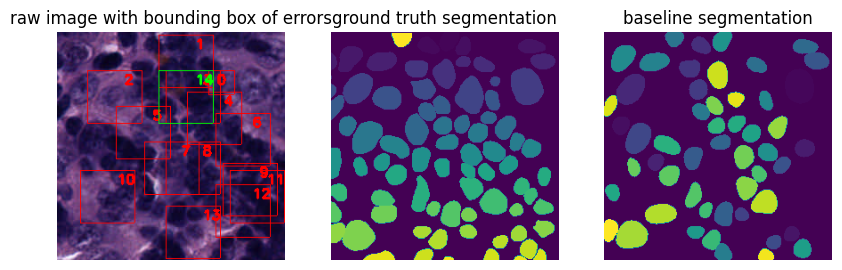

0.2301466464996338 draw squares
0.05352044105529785 find_nearest_nuclei
0.07552933692932129 norm 
0.005690574645996094 draw squares
0.012126684188842773 find_nearest_nuclei
0.012255668640136719 norm 
0.0004284381866455078 draw squares
0.012240171432495117 find_nearest_nuclei
0.01543879508972168 norm 
0.00441741943359375 draw squares
0.01205897331237793 find_nearest_nuclei
0.015776872634887695 norm 
0.003815889358520508 draw squares
0.012136220932006836 find_nearest_nuclei
0.016921043395996094 norm 
0.00012302398681640625 draw squares
0.012103796005249023 find_nearest_nuclei
0.017687559127807617 norm 
0.0003085136413574219 draw squares
0.012473821640014648 find_nearest_nuclei
0.018089771270751953 norm 
0.00038695335388183594 draw squares
0.012146711349487305 find_nearest_nuclei
0.017660140991210938 norm 
0.008280038833618164 draw squares
0.012416601181030273 find_nearest_nuclei
0.01671457290649414 norm 
0.011113882064819336 draw squares
0.01225423812866211 find_nearest_nuclei
0.01746773

In [11]:
idx_patch_clicked = 210
t1 = time()
f.extract_errors(idx_patch_clicked)
t2 = time()
f.show_errors_loc()
t3 = time()
f.threshold_images = 0.4
f.select_images_near()
f.threshold_nucleis = 0.2
t4 = time()
(
    images_near,
    images_with_same_errors_detected,
    sub_dataset,
    grids,
    filenames_near,
) = f.find_same_nuclei()

t5 = time()
print(t5 - t4)
print(t4 - t3)
print(t3 - t2)
print(t2 - t1)
print(len(images_with_same_errors_detected))
print(len(filenames_near))

In [12]:
from clickref.dataloader import CustomImageDataset

In [13]:
dataset_test = CustomImageDataset(
    path_baseline=path_stardist,
    path_images=path_images,
    path_gt=path_gt,
    dataframe=df_test,
    augmenter_bool=False,
)
loader_test = DataLoader(
    batch_size=parameters["batch_size"],
    dataset=dataset_test,
    shuffle=False,

)

fp 6
merge 0
split 0
fn 566


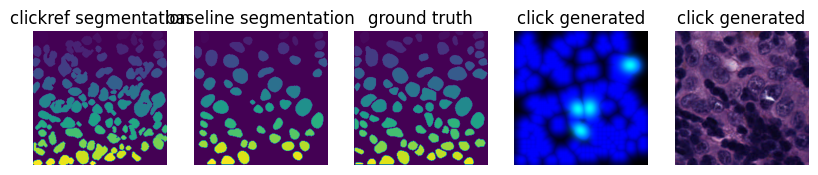

fp 0
merge 0
split 0
fn 1


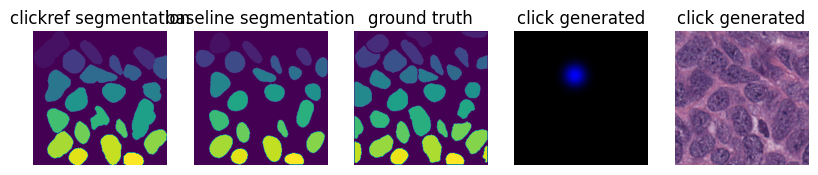

fp 0
merge 0
split 0
fn 1


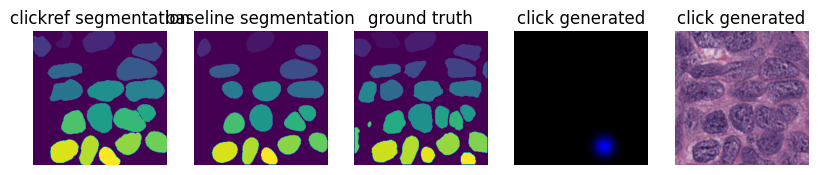

fp 0
merge 0
split 0
fn 133


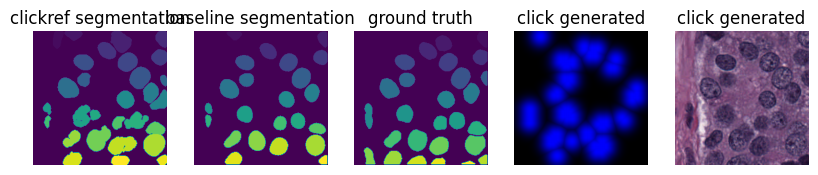

fp 3
merge 0
split 0
fn 87


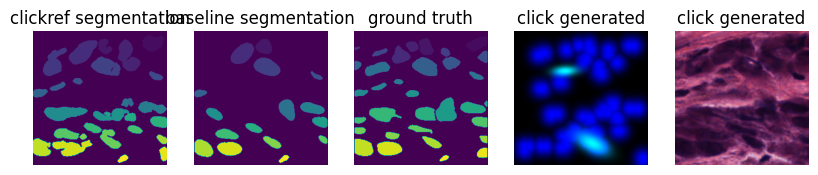

fp 0
merge 0
split 0
fn 2


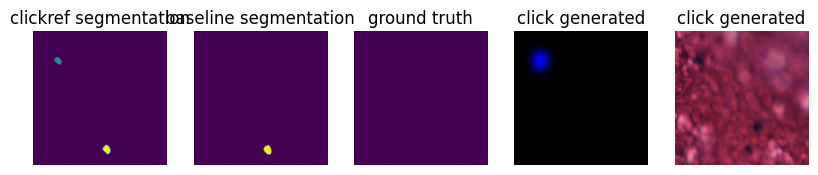

fp 0
merge 0
split 0
fn 140


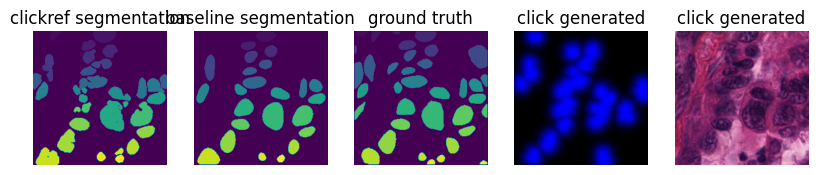

fp 0
merge 0
split 0
fn 21


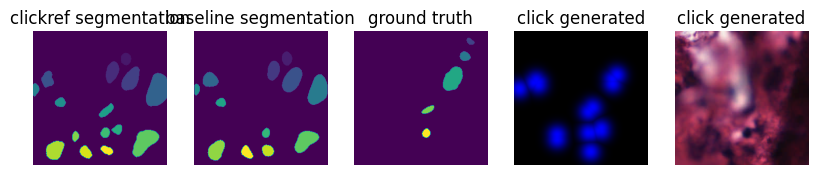

fp 0
merge 0
split 0
fn 30


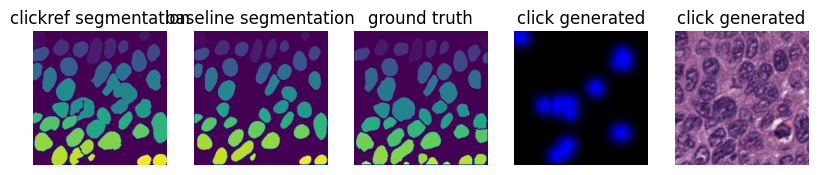

fp 1
merge 0
split 0
fn 109


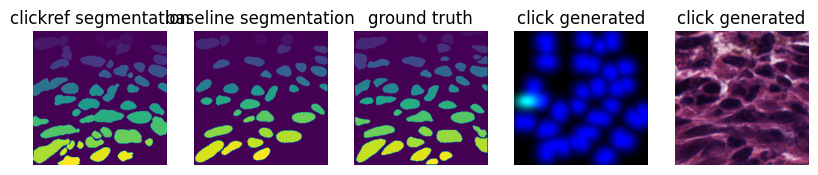

In [49]:
# if len(images_with_same_errors_detected)>1:
#     for index in images_with_same_errors_detected[1:][:10]:
#         filename = filenames_near[index]
#         grid = grids[index]

#         g = Grid_to_click(grid, filename, path_baseline)
#         click = torch.tensor(np.moveaxis(g.final_click(),-1,0))[None].float()
#         filename_to_index = loader_test.dataset.dataframe.reset_index(drop=True)
#         index = filename_to_index[filename_to_index['filename']==filename].index[0]
#         image, baseline, gt, click_manual = loader_test.dataset.__getitem__(index)
#         pred_outputs = clickref(image[None], click, baseline[None])[0]

#         prediction = post_processing(disk_size=2, size_erase=20, pred = pred_outputs.detach().numpy(), not_pred=baseline.detach().numpy(), is_pred = True).astype(int)
#         baseline_post_processed = post_processing(disk_size=2, size_erase=20, pred = None, not_pred=baseline.detach().numpy(), is_pred = False).astype(int)
#         gt_post_processed = post_processing(disk_size=2, size_erase=20, pred = None, not_pred=gt.detach().numpy(), is_pred = False).astype(int)
    
#         image = np.moveaxis(image.detach().numpy(),0,-1)
#         click_manual = np.moveaxis(click_manual.detach().numpy(),0,-1)
#         fig = plt.figure(figsize=(10, 7))
#         # setting values to rows and column variables

        
#         rows = 1
#         columns = 5



#         # Adds a subplot at the 1st position
#         fig.add_subplot(rows, columns, 1)
#         # prediction = np.argmax(np.moveaxis(pred_outputs.detach().numpy()[0],0,-1) + baseline, axis=-1)
#         # showing image
#         plt.imshow(prediction)
#         plt.axis("off")
#         plt.title("clickref segmentation")

#         # Adds a subplot at the 2nd position
#         fig.add_subplot(rows, columns, 2)

#         # showing image
#         plt.imshow(baseline_post_processed)
#         plt.axis("off")
#         plt.title("baseline segmentation")

#         # Adds a subplot at thhttp://127.0.0.1:8888/?token=43a6d73987507a6a37f317f6ca6dcc2b0cb958224835ee73e 3rd position
#         fig.add_subplot(rows, columns, 3)

#         # showing image
#         plt.imshow(gt_post_processed)
#         plt.axis("off")
#         plt.title("ground truth")

#         fig.add_subplot(rows, columns, 4)

#         plt.imshow(n_channel_to_rgb(np.moveaxis(click[0].detach().numpy(),0,-1)))
#         plt.axis("off")
#         plt.title("click generated")

#         fig.add_subplot(rows, columns, 5)

#         plt.imshow(image)
#         plt.axis("off")
#         plt.title("click generated")
#         plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


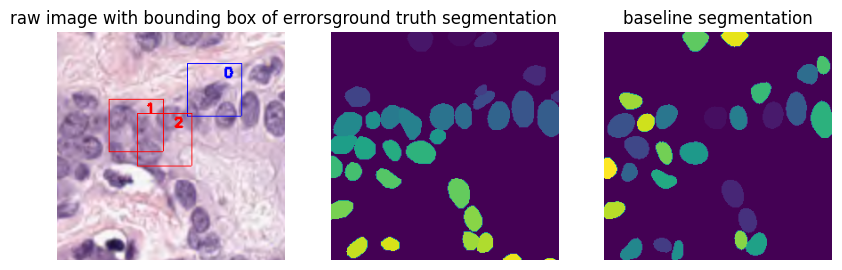

0.00032806396484375 draw squares
0.01820850372314453 find_nearest_nuclei
0.11749458312988281 norm 
0.00019240379333496094 draw squares
0.018240928649902344 find_nearest_nuclei
0.06791877746582031 norm 
0.0005481243133544922 draw squares
0.01770758628845215 find_nearest_nuclei
0.04447507858276367 norm 
164
9


In [105]:
idx_patch_clicked = 10
t1 = time()
f.extract_errors(idx_patch_clicked)
t2 = time()
f.show_errors_loc()
t3 = time()
f.threshold_images = 0.3
f.select_images_near()
f.threshold_nucleis = 0.4
t4 = time()
(
    images_near,
    images_with_same_errors_detected,
    sub_dataset,
    grids,
    filenames_near,
) = f.find_same_nuclei()
print(len(images_near))
print(len(images_with_same_errors_detected))

In [110]:
nb_images_to_correct = images_with_same_errors_detected[1:10].shape[0]
results = np.zeros((nb_images_to_correct,2,6))
if len(images_with_same_errors_detected)>1:
    for k, index in enumerate(images_with_same_errors_detected[1:10]):
        filename = filenames_near[index]
        grid = grids[index]

        g = Grid_to_click(grid, filename, path_baseline)
        click = torch.tensor(np.moveaxis(g.final_click(),-1,0))[None].float()
        filename_to_index = loader_test.dataset.dataframe.reset_index(drop=True)
        index = filename_to_index[filename_to_index['filename']==filename].index[0]
        image, baseline, gt, click_manual = loader_test.dataset.__getitem__(index)
        pred_outputs = clickref(image[None], click, baseline[None])[0]

        prediction = post_processing(disk_size=2, size_erase=20, pred = pred_outputs.detach().numpy(), not_pred=baseline.detach().numpy(), is_pred = True).astype(int)
        baseline_post_processed = post_processing(disk_size=2, size_erase=20, pred = None, not_pred=baseline.detach().numpy(), is_pred = False).astype(int)
        gt_post_processed = post_processing(disk_size=2, size_erase=20, pred = None, not_pred=gt.detach().numpy(), is_pred = False).astype(int)
        
        match_pred = matching(gt_post_processed, prediction)
        match_baseline = matching(gt_post_processed, baseline_post_processed)

        results[k,:,0] = match_pred.precision, match_baseline.precision
        results[k,:,1] = match_pred.recall, match_baseline.recall
        results[k,:,2] = match_pred.f1, match_baseline.f1
        results[k,:,3] = match_pred.panoptic_quality, match_baseline.panoptic_quality
        results[k,:,4] = AJI(prediction, gt_post_processed), AJI(baseline_post_processed, gt_post_processed)
        results[k,:,5] = DICE(prediction, gt_post_processed), DICE(baseline_post_processed, gt_post_processed)

mean_results = np.mean(results,0)
table = BeautifulTable()
table.rows.append(['click_ref']+list(mean_results[0]))
table.rows.append(['baseline']+list(mean_results[1]))

table.columns.header = [
    "model",
    "Precision",
    "Recall",
    "F1",
    "PANOPTIC",
    "AJI",
    "ADICE",
]       

fp 0
merge 0
split 0
fn 1
fp 0
merge 0
split 0
fn 1
fp 0
merge 0
split 0
fn 2
fp 0
merge 0
split 0
fn 2
fp 0
merge 1
split 0
fn 0
fp 0
merge 0
split 0
fn 1
fp 0
merge 1
split 0
fn 2
fp 0
merge 1
split 0
fn 0


In [111]:
print(table)

+-----------+-----------+--------+-------+----------+-------+-------+
|   model   | Precision | Recall |  F1   | PANOPTIC |  AJI  | ADICE |
+-----------+-----------+--------+-------+----------+-------+-------+
| click_ref |   0.863   | 0.644  | 0.735 |   0.58   | 0.491 | 0.648 |
+-----------+-----------+--------+-------+----------+-------+-------+
| baseline  |    0.9    | 0.653  | 0.753 |  0.591   | 0.492 | 0.647 |
+-----------+-----------+--------+-------+----------+-------+-------+


In [57]:
np.mean(results,0).shape

(2, 7)

In [109]:
nb_images_to_correct = images_with_same_errors_detected[1:10].shape[0]
results = np.zeros((nb_images_to_correct,2,7))
if len(images_with_same_errors_detected)>1:
    for k, index in enumerate(nb_images_to_correct):
        filename = filenames_near[index]
        grid = grids[index]

        g = Grid_to_click(grid, filename, path_baseline)
        click = torch.tensor(np.moveaxis(g.final_click(),-1,0))[None].float()
        filename_to_index = loader_test.dataset.dataframe.reset_index(drop=True)
        index = filename_to_index[filename_to_index['filename']==filename].index[0]
        image, baseline, gt, click_manual = loader_test.dataset.__getitem__(index)
        pred_outputs = clickref(image[None], click, baseline[None])[0]

        prediction = post_processing(disk_size=2, size_erase=20, pred = pred_outputs.detach().numpy(), not_pred=baseline.detach().numpy(), is_pred = True).astype(int)
        baseline_post_processed = post_processing(disk_size=2, size_erase=20, pred = None, not_pred=baseline.detach().numpy(), is_pred = False).astype(int)
        gt_post_processed = post_processing(disk_size=2, size_erase=20, pred = None, not_pred=gt.detach().numpy(), is_pred = False).astype(int)
        
        match_pred = matching(gt_post_processed, prediction)
        match_baseline = matching(gt_post_processed, baseline_post_processed)

        results[k,:,0] = match_pred.precision, match_baseline.precision
        results[k,:,1] = match_pred.recall, match_baseline.recall
        results[k,:,2] = match_pred.f1, match_baseline.f1
        results[k,:,3] = match_pred.panoptic_quality, match_baseline.panoptic_quality
        results[k,:,4] = AJI(prediction, gt_post_processed), AJI(baseline_post_processed, gt_post_processed)
        results[k,:,5] = DICE(prediction, gt_post_processed), DICE(baseline_post_processed, gt_post_processed)

        # mean_res = np.mean(results, axis = 0)
        # res_pred, res_base = mean_res[0], mean_res[1]
        # table = BeautifulTable()
        # table.rows.append(['click_ref']+list(res_pred))
        # table.rows.append(['baseline']+list(res_base))

    #     table.columns.header = [
    #         "model",
    #         "Precision",
    #         "Recall",
    #         "F1",
    #         "PANOPTIC",
    #         "AJI",
    #         "ADICE",
    #     ]
    #     print(table)
    # return table
        

TypeError: 'int' object is not iterable

In [ ]:
from clickref.dataloader import loader_test

In [ ]:
image, baseline, gt, click = loader_test.dataset.__getitem__(6)

In [ ]:
prediction_numpy = torch.argmax(clickref(image[None],click[None],baseline[None])+baseline[None],axis=1)[0].detach().numpy()
image_numpy = torch.roll(image, shifts, dims=None)image.detach().numpy()


In [ ]:
index = 0
filename = filenames_near[index]
grid = grids[index]
path_baseline = path_stardist
g = Grid_to_click(grid, filename, path_baseline)
click = g.final_click()

arr_baselines, arr_gts, arr_preds, arr_clicks = test_clickref(clickref, loader_test)
bef, out, baseline = model_predict_with_click(
    filename,
    clickref,
    path_baseline,
    click,
    count_erase=15,
    radius=3,
)
baseline = tifffile.imread(os.path.join(path_baseline,'baseline', filename))
gt = tifffile.imread(os.path.join(path_gt,'baseline',filename))

plt.imshow(bef, cmap ='nipy_spectral')
plt.show()
plt.imshow(baseline, cmap ='nipy_spectral')
plt.show()
plt.imshow(gt, cmap ='nipy_spectral')
plt.show()
plt.imshow(np.amax(click,-1))